# HOMEWORK 6

In [21]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

(<Axes: >, <matplotlib.image.AxesImage at 0x7fad0a16d410>)

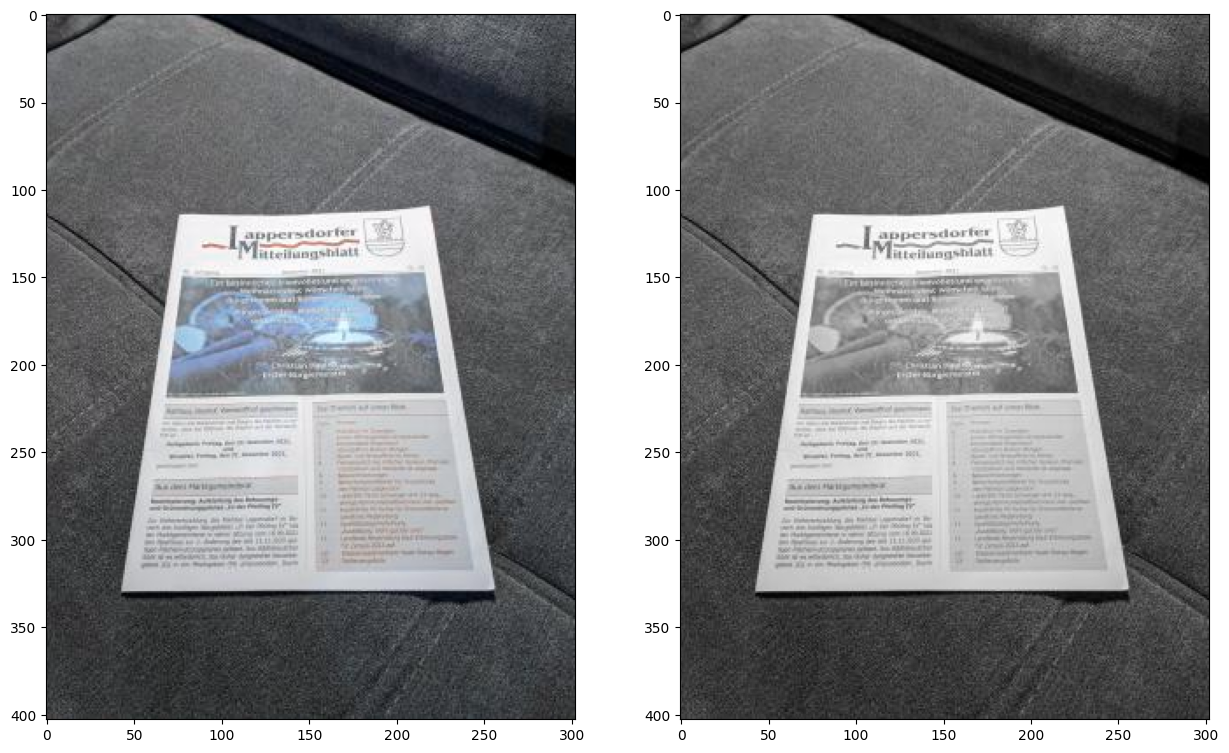

In [22]:
# Let's read the image
img = cv2.imread('data/document.jpg')
# Convert it to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# Normalize to float32 type
gray = np.float32(gray)/255
rows, cols = gray.shape

# Let's plot the images (colour and gray scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

### Harris Corner Detector

In [23]:
# Compute Harris corners (using the available OpenCV functions)
# Using block size of 2 pixels, gradient kernel size of 3 pixels, and k parameter equal to 0.04
cornerness = cv2.cornerHarris(gray, 2, 3, 0.04)

# We are not interested in edges, so put to zero all negative cornerness values
cornerness = np.maximum(cornerness, 0)

# Since cornerness has a huge dynamic range, let's take the logarithm for better visualization and manipulation
cornerness = np.log(cornerness + 1e-6)

(<Axes: >, <matplotlib.image.AxesImage at 0x7fad20185dd0>)

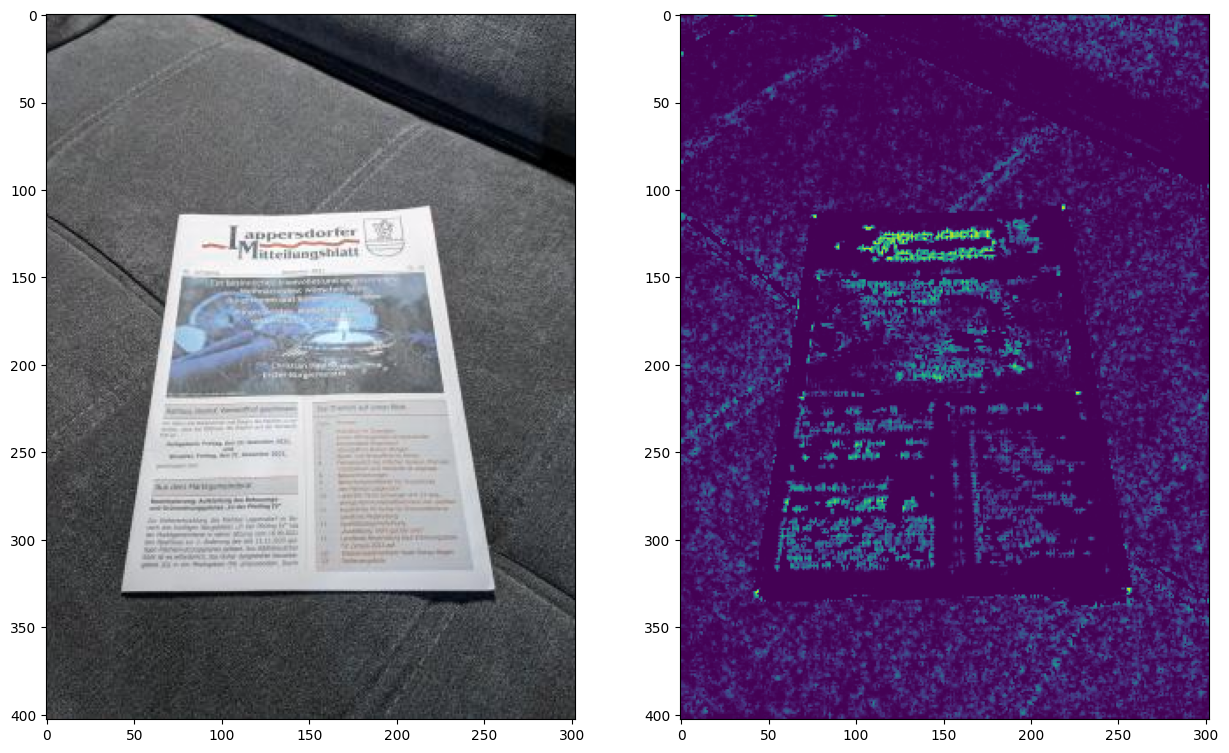

In [24]:
# Let's now plot the image and the corresponding Harris corners (in log scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(cornerness)

(<Axes: >, <matplotlib.image.AxesImage at 0x7fad0a1bc910>)

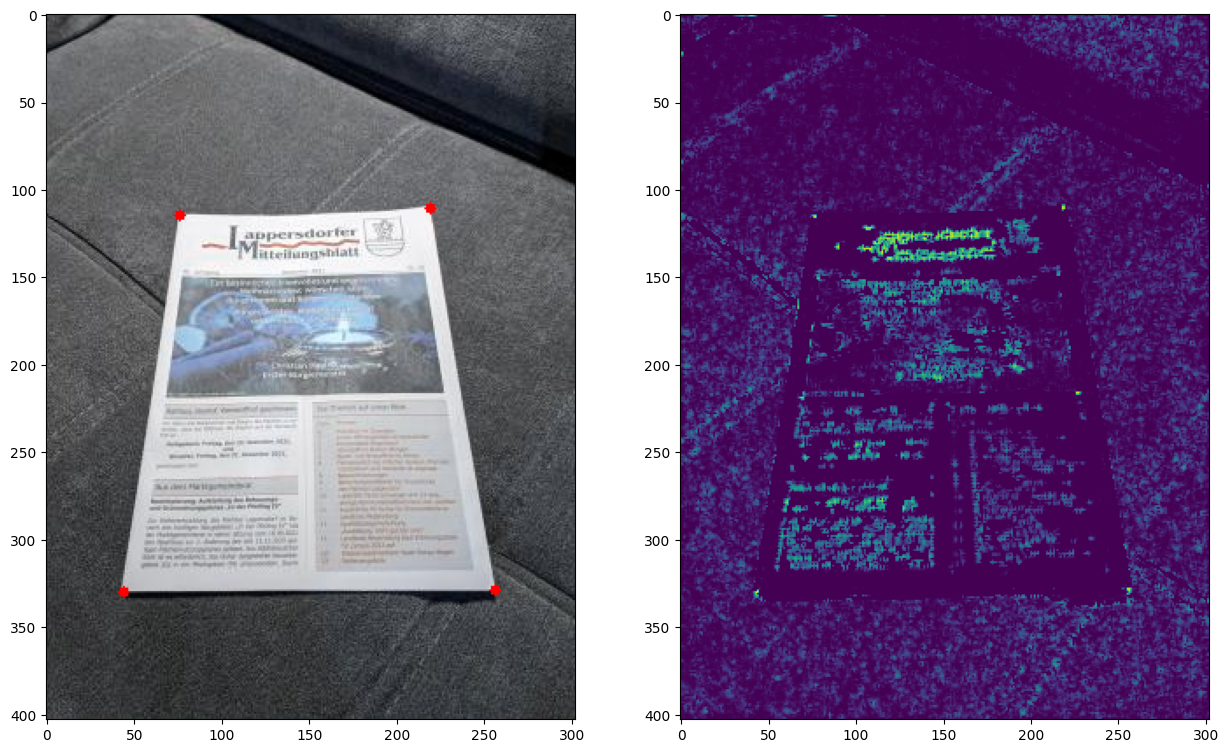

In [25]:
# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_ritgh = None, None

# Size of each quadrant (in pixels)
quad_size = 7

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        if cornerness[r, c] < -7:
            continue
        
        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]

        # Extract the four quadrants
        quad_top_left = block[0:quad_size, 0:quad_size]
        quad_top_right = block[0:quad_size, quad_size:2 * quad_size]
        quad_bottom_left = block[quad_size:2 * quad_size, 0:quad_size]
        quad_bottom_right = block[quad_size:2 * quad_size, quad_size:2 * quad_size]
        
        # Top-left corner
        # For the top-left document corner, the bottom-right quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants
        descriptor = np.mean(quad_bottom_right) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_top_left:
            # We update the threshold
            th_top_left = descriptor
            # And we update the optimal location
            opt_top_left = (c, r)
        
        # Top-Right corner (Main quadrant: Bottom-Left)
        descriptor = np.mean(quad_bottom_left) - \
                     (np.mean(quad_top_left) + np.mean(quad_top_right) + np.mean(quad_bottom_right))
        if descriptor > th_top_right:
            th_top_right = descriptor
            opt_top_right = (c, r)

        # Bottom-Left corner (Main quadrant: Top-Right)
        descriptor = np.mean(quad_top_right) - \
                     (np.mean(quad_top_left) + np.mean(quad_bottom_left) + np.mean(quad_bottom_right))
        if descriptor > th_bottom_left:
            th_bottom_left = descriptor
            opt_bottom_left = (c, r)
        
        # Bottom-Right corner (Main quadrant: Top-Left)
        descriptor = np.mean(quad_top_left) - \
                     (np.mean(quad_top_right) + np.mean(quad_bottom_left) + np.mean(quad_bottom_right))
        if descriptor > th_bottom_right:
            th_bottom_right = descriptor
            opt_bottom_right = (c, r)

# Let's draw circles at the detected corners
out = cv2.circle(img, opt_top_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_top_right, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_right, 3, (255,0,0), -1)

# And finally we plot the images (with the detected document corners)
plt.subplot(121), plt.imshow(out)
plt.subplot(122), plt.imshow(cornerness)

### Questions

##### Does it matter whether the picture has been taken by a 1Mpx camera or a 12Mpx camera? How?

- An image with a higher resolution will contain significantly more pixels and the photo will be much more detailed. Which can both lead to greater accuracy in the definition of functions and increase the calculation time and slow down the processing time

##### If we increased the resolution of the camera, what would you change in the current algorithm?
- A higher resolution can provide more detailed and accurate angle detection results

- For the Harris corners method, we will need to change the parameters (block size, gradient kernel size, k) and play with them to get the best results.
- And it will also be necessary to increase the size of each quadrant. Threshold values ​​(th_top_left, th_top_right, etc.) may also require adjustment.

- Also, keep in mind that the angle measure depends on the gradients in the image, and these gradients can potentially change as the image resolution increases.

